# Early Financial Stress Detection (Loan Risk) — End-to-End ML Project (Real Banking Data)

This notebook is **portfolio-ready** and designed to run **without path errors**.

## What this notebook does (high level)
You will build an **early-warning** model for loan risk using a **real multi-table banking dataset**:
- **Loan table** (loan outcomes)
- **Account table** (customer/account metadata)
- **Transactions table** (behavior history)

## Key idea (what makes this project “real”)
We create features using **only transactions that happened BEFORE the loan date** (temporal constraint).  
That avoids **data leakage** and mirrors real risk analytics work.

## Outputs you will produce
- Clean EDA visuals (loan volumes, class balance, distributions)
- Time-aware transaction behavior features (monthly + cumulative)
- Multiple ML models (LogReg / RandomForest / GradientBoosting)
- ROC + PR curves, confusion matrix plot
- Feature importance (top drivers)
- Risk score output for underwriting-style ranking


## 1) Imports and settings

This cell loads the libraries we need for:
- data processing (pandas/numpy)
- plotting (matplotlib)
- modeling & evaluation (scikit-learn)

**Tip:** If a library is missing, install it with `pip install <package>`.


In [53]:
# ============================================================
# 1) Imports + settings
# ============================================================
import os
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

RANDOM_STATE = 42
print("Imports loaded ✅")

Imports loaded ✅


## 2) Download the real dataset (auto)

To avoid file path issues, the notebook downloads the data automatically into a local folder called **`data/`**.

Dataset files (TSV):
- `fin_loan.tsv`
- `fin_account.tsv`
- `fin_trans.tsv`


In [55]:
# ============================================================
# 2) Download real dataset (TSV) into ./data
# ============================================================
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

BASE_RAW = "https://raw.githubusercontent.com/dnoeth/1999_Czech_financial_dataset_Teradata/master/"

FILES = {
    "loan": "fin_loan.tsv",
    "account": "fin_account.tsv",
    "trans": "fin_trans.tsv",
}

def download_if_missing(filename: str) -> Path:
    path = DATA_DIR / filename
    if path.exists():
        print(f"Found locally: {path}")
        return path
    url = BASE_RAW + filename
    print(f"Downloading: {url}")
    urllib.request.urlretrieve(url, path)
    print(f"Saved: {path}")
    return path

loan_path = download_if_missing(FILES["loan"])
account_path = download_if_missing(FILES["account"])
trans_path = download_if_missing(FILES["trans"])

loan_path, account_path, trans_path

Found locally: data\fin_loan.tsv
Found locally: data\fin_account.tsv
Found locally: data\fin_trans.tsv


(WindowsPath('data/fin_loan.tsv'),
 WindowsPath('data/fin_account.tsv'),
 WindowsPath('data/fin_trans.tsv'))

## 3) Load tables safely (handles header issues)

Sometimes TSV files are exported with/without headers.  
This cell loads each table robustly:
- If the expected columns are missing, we re-load with explicit column names.


In [57]:
# ============================================================
# 3) Load tables robustly (handles schema/header variations)
# ============================================================
def read_tsv(path: Path, expected_cols=None, names_if_no_header=None):
    """Read a TSV and if headers are missing, fall back to header=None with provided names."""
    df = pd.read_csv(path, sep="\t", low_memory=False)
    if expected_cols is not None and not set(expected_cols).issubset(set(df.columns)):
        # likely no header or wrong header -> reload with explicit names
        df = pd.read_csv(path, sep="\t", header=None, names=names_if_no_header, low_memory=False)
    return df

# Expected schemas (most common for this dataset export)
loan_expected = ["loan_id", "account_id", "date", "amount", "duration", "payments", "status"]
account_expected = ["account_id", "district_id", "frequency", "date"]
trans_expected = ["trans_id", "account_id", "date", "type", "operation", "amount", "balance", "k_symbol", "bank", "account"]

loan = read_tsv(loan_path, expected_cols=["account_id", "status"], names_if_no_header=loan_expected)
account = read_tsv(account_path, expected_cols=["account_id"], names_if_no_header=account_expected)
trans = read_tsv(trans_path, expected_cols=["account_id", "date"], names_if_no_header=trans_expected)

# Clean column names (strip spaces)
loan.columns = loan.columns.astype(str).str.strip()
account.columns = account.columns.astype(str).str.strip()
trans.columns = trans.columns.astype(str).str.strip()

print("Loan columns:", loan.columns.tolist())
print("Account columns:", account.columns.tolist())
print("Trans columns:", trans.columns.tolist())

display(loan.head(3))
display(account.head(3))
display(trans.head(3))

Loan columns: ['loan_id', 'account_id', 'date', 'amount', 'duration', 'payments', 'status']
Account columns: ['account_id', 'district_id', 'frequency', 'date']
Trans columns: ['trans_id', 'account_id', 'date', 'type', 'operation', 'amount', 'balance', 'k_symbol', 'bank', 'account']


,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,2014-01-05,8095.2,24,337.3,A
1,4961,19,2016-04-29,3027.6,12,252.3,B
2,4962,25,2017-12-08,3027.6,12,252.3,A


,account_id,district_id,frequency,date
0,1,18,2015-03-24,M
1,2,1,2013-02-26,M
2,3,5,2017-07-07,M


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,2015-03-24,100.0,100.00,C,CIC,,NaN,NaN
1,5,1,2015-04-13,367.9,467.90,C,COB,,AB,41403269.0
2,6,1,2015-05-13,367.9,2097.72,C,COB,,AB,41403269.0


## 4) Clean + parse dates

We create:
- `loan_date` from loan table
- `trans_date` from transactions table

This is robust to formats like:
- `2014-01-05`
- `20140105`
- `990101` (older style)


In [59]:
# ============================================================
# 4) Clean + parse dates (robust)
# ============================================================
def parse_date_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    # try direct parse first (handles 'YYYY-MM-DD')
    dt1 = pd.to_datetime(s, errors="coerce")
    # for non-parsed, strip non-digits and try numeric formats
    s2 = s.str.replace(r"\D", "", regex=True).replace("nan", np.nan)
    dt2 = pd.to_datetime(s2, format="%Y%m%d", errors="coerce")
    # fallback: yymmdd -> assume 19yy (fits PKDD era)
    dt3 = pd.to_datetime("19" + s2, format="%Y%m%d", errors="coerce")

    # combine in priority order
    dt = dt1.copy()
    dt = dt.fillna(dt2)
    dt = dt.fillna(dt3)
    return dt

# Find loan date column name
loan_date_col = "date" if "date" in loan.columns else ("date_loan" if "date_loan" in loan.columns else None)
if loan_date_col is None:
    raise ValueError(f"No recognizable loan date column. Loan columns: {loan.columns.tolist()}")

loan["loan_date"] = parse_date_series(loan[loan_date_col])
trans["trans_date"] = parse_date_series(trans["date"])

print("Loan date parsed %:", loan["loan_date"].notna().mean())
print("Trans date parsed %:", trans["trans_date"].notna().mean())

display(loan[[c for c in ['loan_id','account_id',loan_date_col,'loan_date','status','amount'] if c in loan.columns]].head(5))
display(trans[['account_id','date','trans_date']].head(5))

Loan date parsed %: 1.0
Trans date parsed %: 1.0


,loan_id,account_id,date,loan_date,status,amount
0,4959,2,2014-01-05,2014-01-05,A,8095.2
1,4961,19,2016-04-29,2016-04-29,B,3027.6
2,4962,25,2017-12-08,2017-12-08,A,3027.6
3,4967,37,2018-10-14,2018-10-14,D,31848.0
4,4968,38,2018-04-19,2018-04-19,C,11073.6


,account_id,date,trans_date
0,1,2015-03-24,2015-03-24
1,1,2015-04-13,2015-04-13
2,1,2015-05-13,2015-05-13
3,1,2015-06-13,2015-06-13
4,1,2015-07-13,2015-07-13


## 5) Define target label (good vs bad loans)

Loan status codes typically include:
- **A** = good (finished, paid)
- **B** = bad (finished, default / unpaid)
- **C/D** = unfinished (we exclude those to avoid ambiguity/leakage)

We keep only A and B.


In [61]:
# ============================================================
# 5) Target creation
# ============================================================
loan["status"] = loan["status"].astype(str).str.strip()

loan_finished = loan[loan["status"].isin(["A", "B"])].copy()
loan_finished["target_bad"] = (loan_finished["status"] == "B").astype(int)  # 1=bad, 0=good

print("Finished loans:", loan_finished.shape)
print(loan_finished["status"].value_counts())
loan_finished.head()

Finished loans: (234, 9)
status
A    203
B     31
Name: count, dtype: int64


,loan_id,account_id,date,amount,duration,payments,status,loan_date,target_bad
0,4959,2,2014-01-05,8095.2,24,337.3,A,2014-01-05,0
1,4961,19,2016-04-29,3027.6,12,252.3,B,2016-04-29,1
2,4962,25,2017-12-08,3027.6,12,252.3,A,2017-12-08,0
5,4973,67,2016-05-02,16596.0,24,691.5,A,2016-05-02,0
6,4986,97,2017-08-10,10287.6,12,857.3,A,2017-08-10,0


## 6) EDA (visuals)

We look at:
- class balance (A vs B)
- loan amount distributions
- loans over time


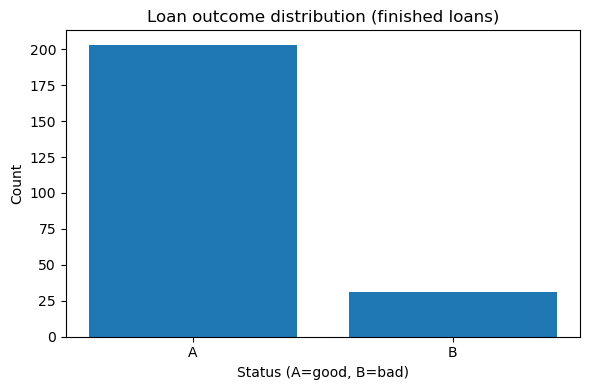

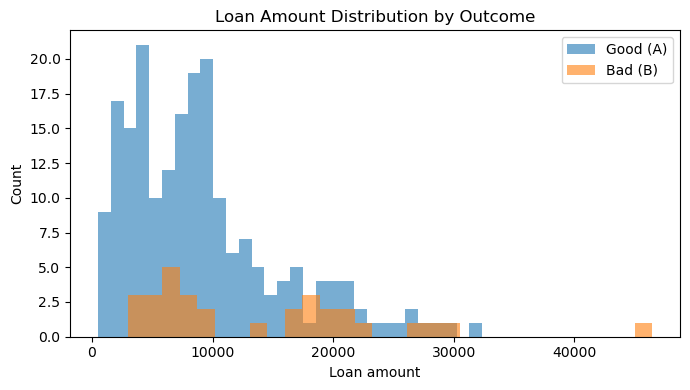

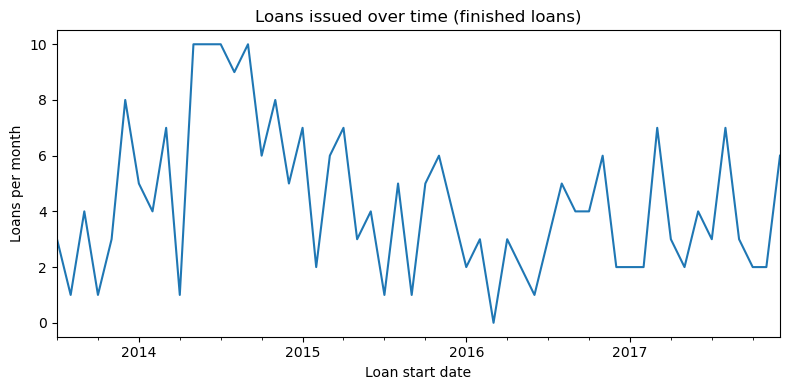

In [63]:
# ============================================================
# 6) EDA visuals
# ============================================================
counts = loan_finished["status"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Loan outcome distribution (finished loans)")
plt.xlabel("Status (A=good, B=bad)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Loan amount distribution by outcome
plt.figure(figsize=(7,4))
good = loan_finished.loc[loan_finished["target_bad"]==0, "amount"].astype(float)
bad = loan_finished.loc[loan_finished["target_bad"]==1, "amount"].astype(float)
plt.hist(good, bins=30, alpha=0.6, label="Good (A)")
plt.hist(bad, bins=30, alpha=0.6, label="Bad (B)")
plt.title("Loan Amount Distribution by Outcome")
plt.xlabel("Loan amount")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Loans per month (use month-end alias 'ME' to avoid FutureWarning)
tmp = loan_finished.dropna(subset=["loan_date"]).copy()
tmp = tmp.set_index("loan_date").sort_index()
plt.figure(figsize=(8,4))
tmp["amount"].resample("ME").count().plot()
plt.title("Loans issued over time (finished loans)")
plt.xlabel("Loan start date")
plt.ylabel("Loans per month")
plt.tight_layout()
plt.show()

## 7) Feature engineering (time-aware)

We create transaction-based features for each loan using **only transactions up to the loan date**.

Approach:
1. Convert transactions into **monthly** aggregates per account.
2. Create **cumulative** behavior features over time.
3. For each loan date, pick the most recent month <= loan date (**merge_asof**).


In [65]:
# ============================================================
# 7) Feature engineering with temporal constraint
# ============================================================
# Safety checks
for df_name, df in [("loan_finished", loan_finished), ("account", account), ("trans", trans)]:
    if "account_id" not in df.columns:
        raise ValueError(f"'account_id' missing in {df_name}. Columns: {df.columns.tolist()}")

# Join loan -> account (metadata)
base = loan_finished.merge(account, on="account_id", how="left", suffixes=("", "_acct"))

# Keep only needed transaction columns
keep_cols = ["account_id", "trans_date"]
for c in ["amount", "balance", "type", "operation", "k_symbol"]:
    if c in trans.columns:
        keep_cols.append(c)

trans_small = trans[keep_cols].copy()
trans_small = trans_small.dropna(subset=["trans_date"])

# Numeric cleanup
for col in ["amount", "balance"]:
    if col in trans_small.columns:
        trans_small[col] = pd.to_numeric(trans_small[col], errors="coerce")

# Create month bucket
trans_small["trans_month"] = trans_small["trans_date"].dt.to_period("M").dt.to_timestamp()

# Monthly aggregates
agg = {}
if "amount" in trans_small.columns:
    agg.update({
        "txn_count": ("amount", "size"),
        "amt_sum": ("amount", "sum"),
        "amt_mean": ("amount", "mean"),
        "amt_std": ("amount", "std"),
        "amt_max": ("amount", "max"),
    })
else:
    agg.update({"txn_count": ("account_id", "size")})

if "balance" in trans_small.columns:
    agg.update({
        "bal_mean": ("balance", "mean"),
        "bal_std": ("balance", "std"),
        "bal_min": ("balance", "min"),
        "bal_max": ("balance", "max"),
        "bal_last": ("balance", "last"),
    })

monthly = (
    trans_small.sort_values(["account_id", "trans_month"])
    .groupby(["account_id", "trans_month"])
    .agg(**agg)
    .reset_index()
)

# Cumulative behavior features per account
monthly = monthly.sort_values(["account_id", "trans_month"])
feat_cols = [c for c in monthly.columns if c not in ["account_id", "trans_month"]]
for c in feat_cols:
    monthly[f"cum_{c}"] = monthly.groupby("account_id")[c].cumsum()

# Time-aware merge: for each loan_date, attach last known monthly features
base = base.dropna(subset=["loan_date"]).sort_values(["account_id", "loan_date"])
monthly = monthly.sort_values(["account_id", "trans_month"])

# Ensure datetime
base["loan_date"] = pd.to_datetime(base["loan_date"], errors="coerce")
monthly["trans_month"] = pd.to_datetime(monthly["trans_month"], errors="coerce")

# Drop missing keys
base = base.dropna(subset=["loan_date", "account_id"]).copy()
monthly = monthly.dropna(subset=["trans_month", "account_id"]).copy()

# IMPORTANT: sort by date first (global sort), then by account_id
base = base.sort_values(["loan_date", "account_id"]).reset_index(drop=True)
monthly = monthly.sort_values(["trans_month", "account_id"]).reset_index(drop=True)

# Now merge
features = pd.merge_asof(
    base,
    monthly,
    left_on="loan_date",
    right_on="trans_month",
    by="account_id",
    direction="backward",
    allow_exact_matches=True
)

cum_cols = [c for c in monthly.columns if c not in ["account_id", "trans_month"]]

# Fill accounts with no prior transactions
fill_cols = [c for c in features.columns if c.startswith("cum_") or c in cum_cols]
features[fill_cols] = features[fill_cols].fillna(0)

print("Feature table shape:", features.shape)
display(features[["account_id","loan_date","status","target_bad"] + fill_cols[:8]].head())

Feature table shape: (234, 33)


,account_id,loan_date,status,target_bad,txn_count,amt_sum,amt_mean,amt_std,amt_max,bal_mean,bal_std,bal_min
0,1787,2013-07-05,B,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1801,2013-07-11,A,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9188,2013-07-28,A,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1843,2013-08-03,A,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11013,2013-09-06,A,0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8) Prepare ML dataset

We build `X` from engineered features and metadata.
We keep:
- numeric features (transaction aggregates, balances, etc.)
- categorical features (frequency, etc.) encoded via OneHotEncoder


In [67]:
# ============================================================
# 8) Prepare ML dataset
# ============================================================
y = features["target_bad"].astype(int)

# Drop target + leakage/ID columns
drop_cols = ["target_bad", "status", "loan_date", "trans_month"]
X = features.drop(columns=drop_cols, errors="ignore")

# Basic ID columns (optional drop, but safe)
for c in ["loan_id"]:
    if c in X.columns:
        X = X.drop(columns=[c])

# Identify categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Numeric cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))
print("Target bad rate:", y.mean().round(4))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("scaler", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

Numeric cols: 25
Categorical cols: 3
Target bad rate: 0.1325


## 9) Train multiple models + compare

We train 3 models:
- Logistic Regression (strong baseline, explainable)
- Random Forest (non-linear, strong tabular baseline)
- Gradient Boosting (often very competitive)

We compare them using:
- ROC-AUC
- Average Precision (PR-AUC)


In [69]:
# ============================================================
# 9) Train models + compare
# ============================================================
models = {
    "LogisticRegression": LogisticRegression(max_iter=3000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        class_weight="balanced_subsample",
        n_jobs=-1,
        min_samples_leaf=2
    ),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

fitted = {}
rows = []

for name, mdl in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", mdl)])
    pipe.fit(X_train, y_train)
    fitted[name] = pipe

    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else pipe.decision_function(X_test)
    roc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    rows.append((name, roc, ap))

results_df = pd.DataFrame(rows, columns=["Model", "ROC_AUC", "AvgPrecision"]).sort_values("ROC_AUC", ascending=False)
results_df

,Model,ROC_AUC,AvgPrecision
0,LogisticRegression,0.745098,0.392090
2,GradientBoosting,0.731618,0.611550
1,RandomForest,0.654412,0.435503


## 10) Evaluation visuals (ROC + PR curves) + confusion matrix

These visuals are what recruiters/interviewers expect:
- ROC curve: how well model separates good vs bad loans
- PR curve: useful when “bad loans” are the minority class
- Confusion matrix: TN/FP/FN/TP


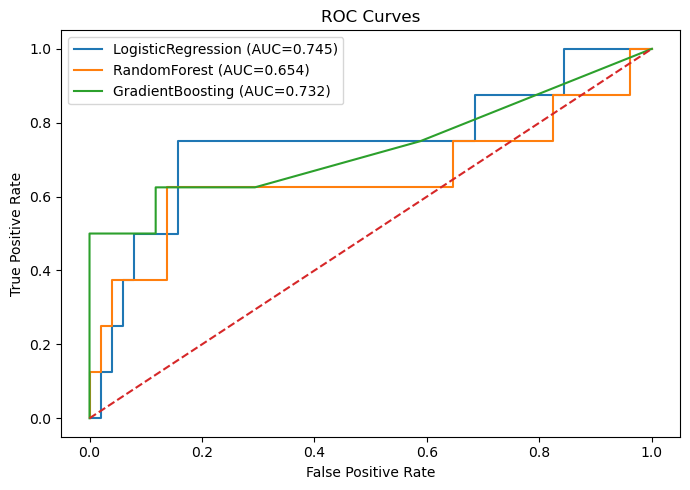

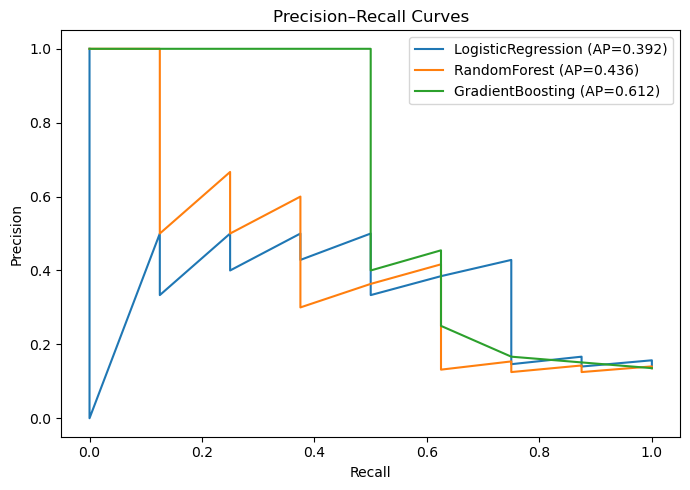

Best model: LogisticRegression


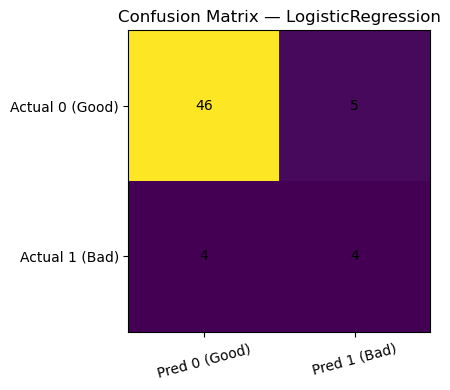

              precision    recall  f1-score   support

           0      0.920     0.902     0.911        51
           1      0.444     0.500     0.471         8

    accuracy                          0.847        59
   macro avg      0.682     0.701     0.691        59
weighted avg      0.856     0.847     0.851        59



In [71]:
# ============================================================
# 10) Evaluation visuals
# ============================================================
plt.figure(figsize=(7,5))
for name, pipe in fitted.items():
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else pipe.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
for name, pipe in fitted.items():
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else pipe.decision_function(X_test)
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

best_name = results_df.iloc[0]["Model"]
best = fitted[best_name]
print("Best model:", best_name)

y_pred = best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4.8,4))
plt.imshow(cm)
plt.title(f"Confusion Matrix — {best_name}")
plt.xticks([0,1], ["Pred 0 (Good)", "Pred 1 (Bad)"], rotation=15)
plt.yticks([0,1], ["Actual 0 (Good)", "Actual 1 (Bad)"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, digits=3))

## 11) Feature importance (top drivers)

For tree models we use `feature_importances_`.  
For Logistic Regression, we use the magnitude of coefficients.

This gives you **interview-ready** explanations:
> “These are the strongest signals contributing to risk.”


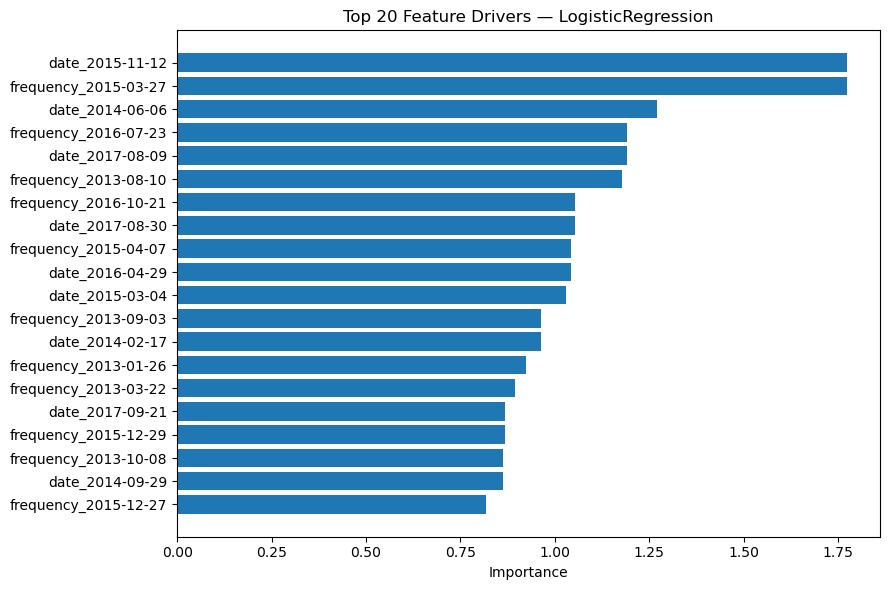

,feature,importance
129,date_2015-11-12,1.772539
298,frequency_2015-03-27,1.772539
64,date_2014-06-06,1.269639
332,frequency_2016-07-23,1.190627
173,date_2017-08-09,1.190627
236,frequency_2013-08-10,1.177212
340,frequency_2016-10-21,1.054399
176,date_2017-08-30,1.054399
299,frequency_2015-04-07,1.042228
136,date_2016-04-29,1.042228


In [73]:
# ============================================================
# 11) Feature importance / coefficients
# ============================================================
# Build feature names after preprocessing
prep = best.named_steps["prep"]

# numeric names
num_feature_names = num_cols

# categorical names
cat_feature_names = []
if len(cat_cols) > 0:
    ohe = prep.named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

feature_names = list(num_feature_names) + cat_feature_names

model = best.named_steps["model"]

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_).ravel()
else:
    importances = np.zeros(len(feature_names))

imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(9,6))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title(f"Top 20 Feature Drivers — {best_name}")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

imp

## 12) Risk scoring example (how a business would use this)

We convert the model’s probability into a **risk score** for ranking.  
This is a very realistic workflow for underwriting / risk review teams:
- Review top-risk accounts first
- Decide manual review / deny / request additional documents


In [75]:
# ============================================================
# 12) Risk scoring output (top risky loans)
# ============================================================
proba = best.predict_proba(X_test)[:, 1] if hasattr(best.named_steps["model"], "predict_proba") else best.decision_function(X_test)

scored = X_test.copy()
scored["risk_score_bad"] = proba
scored["actual_bad"] = y_test.values

# show top 15 highest risk cases
scored.sort_values("risk_score_bad", ascending=False).head(15)

,account_id,date,amount,duration,payments,district_id,frequency,date_acct,txn_count,amt_sum,amt_mean,amt_std,amt_max,bal_mean,bal_std,bal_min,bal_max,bal_last,cum_txn_count,cum_amt_sum,cum_amt_mean,cum_amt_std,cum_amt_max,cum_bal_mean,cum_bal_std,cum_bal_min,cum_bal_max,cum_bal_last,risk_score_bad,actual_bad
70,5120,2014-08-10,32347.2,48,673.9,1,2013-06-21,M,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812332,0
65,2176,2014-07-30,29908.8,36,830.8,67,2013-06-06,M,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788450,1
179,2106,2016-10-03,10152.0,12,846.0,1,2016-02-01,M,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743752,0
63,790,2014-07-24,20812.8,48,433.6,54,2013-05-11,M,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731853,1
126,1762,2015-04-28,24814.8,36,689.3,28,2013-12-11,M,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.719255,0
37,10131,2014-05-02,21538.8,36,598.3,1,2013-11-27,M,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.673098,1
25,1603,2014-02-06,7893.6,12,657.8,1,2013-05-09,M,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579061,0
160,6400,2016-02-12,7240.8,24,301.7,31,2015-10-09,T,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.559933,1
120,2361,2015-04-01,15667.2,36,435.2,28,2014-02-25,M,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506029,0
60,5228,2014-07-11,17380.8,24,724.2,77,2013-06-23,T,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.449205,0


## Interview-ready summary 
- **Dataset:** real multi-table banking dataset (loan + account + transactions).
- **No leakage:** features use only transaction history **before loan date**.
- **Models:** compared Logistic Regression, Random Forest, Gradient Boosting.
- **Evaluation:** ROC/PR curves + confusion matrix.
- **Deliverable:** risk score to rank accounts for underwriting review.
